In [1]:
# 基本ライブラリ
import pandas as pd
import pandas.io.sql as psql
import numpy as np
import numpy.random as rd
import gc
import multiprocessing as mp
import os
import sys
import pickle
from collections import defaultdict
from glob import glob
import math
from datetime import datetime as dt
from pathlib import Path
import scipy.stats as st
import re
import shutil
from tqdm import tqdm_notebook as tqdm
import datetime
ts_conv = np.vectorize(datetime.datetime.fromtimestamp) # 秒ut(10桁) ⇒ 日付

# グラフ描画系
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

from matplotlib import animation as ani
from IPython.display import Image

plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

#カラム内の文字数。デフォルトは50
pd.set_option("display.max_colwidth", 100)

#行数
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
#
pd.options.display.float_format = '{:,.5f}'.format

%matplotlib inline

In [2]:

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold

from sklearn import metrics
import json

import warnings
warnings.filterwarnings("ignore")


sys.path.append('..')
from lib.line_notif import send_message
from lib.utils import reduce_mem_usage, current_time, unpickle, to_pickle
from lib.utils import one_hot_encoder, apply_agg, multi_combine_categorical_feature
from lib.utils import import_data, get_split_indexer 

In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sub = pd.read_csv('../input/sample_submission.csv')
structures = pd.read_csv('../input/structures.csv')

In [32]:
train_type = train.type.values
test_type = test.type.values
to_pickle("train_type.pkl", train_type)
to_pickle("test_type.pkl", test_type)

In [31]:
test_type[:5]

array(['2JHC', '1JHC', '3JHH', '1JHC', '2JHC'], dtype=object)

In [44]:
structures.atom.value_counts().reset_index()

,index,atom
0,H,1208387
1,C,831726
2,O,183187
3,N,132361
4,F,2996


In [57]:
train_type1_cut = train.type=="1JHC"
test_type1_cut = test.type=="1JHC"

train_type2_cut = train.type=="1JHN"
test_type2_cut = test.type=="1JHN"

train_type3_cut = (train.type!="1JHC")&(train.type!="1JHN")
test_type3_cut = (test.type!="1JHC")&(test.type!="1JHN")


In [58]:
train_type1_cut.sum(), train_type2_cut.sum(), train_type3_cut.sum(), train.shape[0]

(709416, 43363, 3905368, 4658147)

In [59]:
assert train_type1_cut.sum()+train_type2_cut.sum()+train_type3_cut.sum()==train.shape[0]
assert test_type1_cut.sum()+test_type2_cut.sum()+test_type3_cut.sum()==test.shape[0]

In [ ]:
np.save()

In [67]:
np.save("../processed/v001/train_type1_cut.npy", train_type1_cut)
np.save("../processed/v001/train_type2_cut.npy", train_type2_cut)
np.save("../processed/v001/train_type3_cut.npy", train_type3_cut)

np.save("../processed/v001/test_type1_cut.npy", test_type1_cut)
np.save("../processed/v001/test_type2_cut.npy", test_type2_cut)
np.save("../processed/v001/test_type3_cut.npy", test_type3_cut)

In [69]:
a = np.load("../processed/v001/train_type1_cut.npy")

In [70]:
a

array([ True, False, False, ..., False, False,  True])

In [35]:
structures.head(10)

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.01270,1.08580,0.00800
1,dsgdb9nsd_000001,1,H,0.00215,-0.00603,0.00198
2,dsgdb9nsd_000001,2,H,1.01173,1.46375,0.00028
3,dsgdb9nsd_000001,3,H,-0.54082,1.44753,-0.87664
4,dsgdb9nsd_000001,4,H,-0.52381,1.43793,0.90640
5,dsgdb9nsd_000002,0,N,-0.04043,1.02411,0.06256
6,dsgdb9nsd_000002,1,H,0.01726,0.01255,-0.02738
7,dsgdb9nsd_000002,2,H,0.91579,1.35875,-0.02876
8,dsgdb9nsd_000002,3,H,-0.52028,1.34353,-0.77554
9,dsgdb9nsd_000003,0,O,-0.03436,0.97754,0.00760


In [40]:
type_df = pd.concat([train.type.value_counts().sort_index(), test.type.value_counts().sort_index()], axis=1)
type_df.columns = ["train", "test"]

In [42]:
type_df.reset_index()

,index,train,test
0,1JHC,709416,380609
1,1JHN,43363,24195
2,2JHC,1140674,613138
3,2JHH,378036,203126
4,2JHN,119253,64424
5,3JHC,1510379,811999
6,3JHH,590611,317435
7,3JHN,166415,90616


In [20]:
train.head(30)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.80760
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.25700
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.25480
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.25430
4,4,dsgdb9nsd_000001,2,0,1JHC,84.80740
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.25410
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.25480
7,7,dsgdb9nsd_000001,3,0,1JHC,84.80930
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.25430
9,9,dsgdb9nsd_000001,4,0,1JHC,84.80950


In [5]:
train.molecule_name.nunique()

85003

In [7]:
np.unique([m.split("_")[0] for m in train.molecule_name.unique()])

array(['dsgdb9nsd'], dtype='<U9')

In [8]:
np.unique([m.split("_")[1] for m in train.molecule_name.unique()])

array(['000001', '000002', '000003', ..., '133881', '133882', '133884'],
      dtype='<U6')

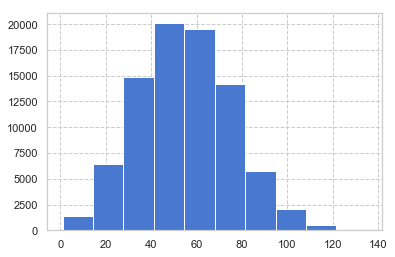

In [13]:
train.groupby("molecule_name").size().sort_values(ascending=False).hist()

In [16]:
train.molecule_name.head()

0    dsgdb9nsd_000001
1    dsgdb9nsd_000001
2    dsgdb9nsd_000001
3    dsgdb9nsd_000001
4    dsgdb9nsd_000001
Name: molecule_name, dtype: object

In [17]:

lbl = LabelEncoder()
lbl.fit(train.molecule_name.values.tolist())
lbl_molecule_name = lbl.transform(train.molecule_name.values.tolist())
to_pickle("lbl_molecule_name.pkl", lbl_molecule_name)

In [22]:
lbl_molecule_name[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
pd.Series(lbl_molecule_name).value_counts().sort_index().values

array([10,  6,  1, ..., 58, 58, 78])

In [23]:
 lbl_molecule_name.shape, (4658147, 448) (2505542, 448) (4658147,)

(4658147,)

In [14]:
train.groupby("molecule_name").size()

molecule_name
dsgdb9nsd_000001     10
dsgdb9nsd_000002      6
dsgdb9nsd_000003      1
dsgdb9nsd_000005      2
dsgdb9nsd_000007     27
dsgdb9nsd_000008     10
dsgdb9nsd_000009     15
dsgdb9nsd_000010     12
dsgdb9nsd_000011     14
dsgdb9nsd_000012      9
dsgdb9nsd_000013     43
dsgdb9nsd_000014     24
dsgdb9nsd_000017     14
dsgdb9nsd_000018     24
dsgdb9nsd_000019     19
dsgdb9nsd_000021     58
dsgdb9nsd_000023      6
dsgdb9nsd_000026      6
dsgdb9nsd_000027      3
dsgdb9nsd_000028      5
dsgdb9nsd_000029     24
dsgdb9nsd_000030     30
dsgdb9nsd_000031     27
dsgdb9nsd_000032     20
dsgdb9nsd_000033     14
dsgdb9nsd_000034     11
dsgdb9nsd_000037     11
dsgdb9nsd_000038     13
dsgdb9nsd_000039     58
dsgdb9nsd_000040     40
dsgdb9nsd_000044     27
dsgdb9nsd_000046     29
dsgdb9nsd_000047     52
dsgdb9nsd_000049     32
dsgdb9nsd_000050     30
dsgdb9nsd_000051     23
dsgdb9nsd_000052     19
dsgdb9nsd_000053     13
dsgdb9nsd_000055     49
dsgdb9nsd_000056     15
dsgdb9nsd_000057     12
ds

In [9]:
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


In [10]:
np.unique([m.split("_")[0] for m in test.molecule_name.unique()])

array(['dsgdb9nsd'], dtype='<U9')

In [11]:
np.unique([m.split("_")[1] for m in test.molecule_name.unique()])

array(['000004', '000015', '000016', ..., '133872', '133883', '133885'],
      dtype='<U6')

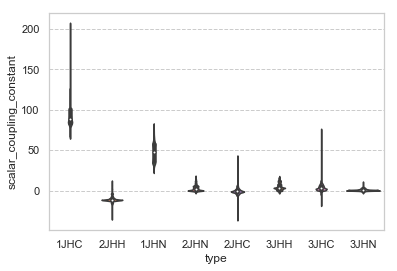

In [64]:
sns.violinplot(data=train, x="type", y="scalar_coupling_constant")

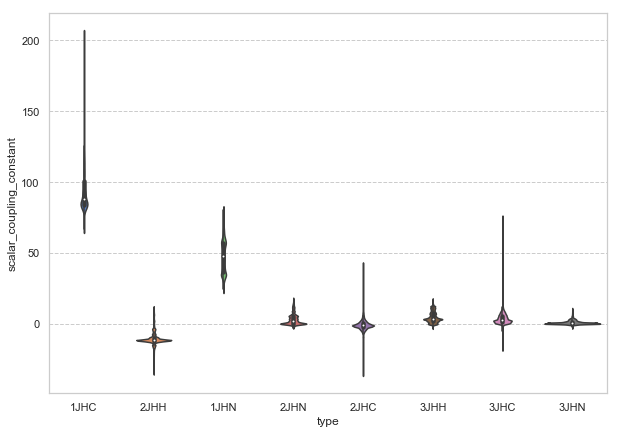

In [66]:
plt.figure(figsize=(10,7))
sns.violinplot(data=train, x="type", y="scalar_coupling_constant", )